In [64]:
import time
start = time.time()
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler, EmbeddingComposite,DWaveSampler 
import pandas as pd
import numpy as np
import seaborn as sns
from distance_matrix_creator import *
import neal

In [65]:
flow = pd.read_csv("flowmatrix.csv", header = None)
flow = (flow.to_numpy()/3)**5
flow = np.round(flow)
flow = np.triu(flow)
print(flow)


distance = distmatrix(9,9)
distance = np.triu(np.array(distance))
print(distance)
print(np.shape(distance))


Nfacil = 13
matrL = 9
positions = []
facilities = [i for i in range(Nfacil)]
positions = [i for i in range(matrL**2)]

print("Facilities = ", facilities)
print("Positions = ",positions)

facility_size = [10,4,7,4,2,1,14,2,14,3,1,3,2]

[[412.  32.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 412.  32.  32.  32.   1.   1.   4.   0.   4.   4.   1.   4.]
 [  0.   0. 412.   4.  13.   1.   0.   0.   0.   0.   0.  -1.   0.]
 [  0.   0.   0. 412.   1.  13.   0.   4.   0.   0.   0.  -1.   0.]
 [  0.   0.   0.   0. 412.   4.  13.   1.   0.   0.   0.  -1.   0.]
 [  0.   0.   0.   0.   0. 412.   1.  13.   0.   1.   0.  -1.   0.]
 [  0.   0.   0.   0.   0.   0. 412.   4.  13.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 412.  13.   1.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 412.  13.  13.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 412.   4.   1.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 412.   1.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 412.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 412.]]
[[ 0.          1.          2.         ... 10.         10.63014581
  11.3137085 ]
 [ 0.          0.          1.     

#Building a variable for each Machine

In [66]:
x = []
for f in facilities:
    x.append([f'F{f}P{p}' for p in positions])
# print(np.array(x))

#Initialise BQM

In [67]:
bqm = BinaryQuadraticModel('BINARY')


#Objective function

In [68]:
for f in range(len(facilities)):
    for f1 in range(f+1,len(facilities)):     
        for p in range(len(positions)):
            for p1 in range(p+1,len(positions)):
                bqm.add_quadratic(x[f][p],x[f1][p1],distance[p][p1]*flow[f][f1]*4.5)

#constraint 1: only 1 machine is placed per position

In [69]:
for p in positions:
    c1 = [(x[f][p],1) for f in facilities]
    bqm.add_linear_inequality_constraint(
        c1,
        ub = 1,
        lb = 0,
        lagrange_multiplier=200,
        label = 'c1_posi_' + str(p),
    )

#Constraint 2: only 1 position is chosen per facility

In [70]:

for f in facilities:
    c2 = [(x[f][p],1) for p in positions]
    bqm.add_linear_equality_constraint(
        c2,
        constant=-1*facility_size[f],
        lagrange_multiplier=800
    )
file = open("bqm.txt", "w")
file.write(str(bqm))
file.close()

Removing 0 bias variables and couplers from BQM

In [71]:

# c3 = [(x[f][p],1) for f in facilities for p in positions]
# bqm.add_linear_equality_constraint(
#     c3,
#     constant=-13,
#     lagrange_multiplier=100
# )

new_bqm = BinaryQuadraticModel(bqm.linear, {interaction: bias for interaction, bias in bqm.quadratic.items() if bias}, bqm.offset, bqm.vartype)

#running the solver

In [72]:
sampler = LeapHybridSampler()
sampleset = sampler.sample(new_bqm, time_limit = 20,)
# sampler = neal.SimulatedAnnealingSampler()
# sampleset = sampler.sample(new_bqm,num_reads = 20000)
# sampler = EmbeddingComposite(DWaveSampler())
# sampleset = sampler.sample(new_bqm, num_reads = 1000)


Printing Output Solutions

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]]

Runtime =  42.51001167297363


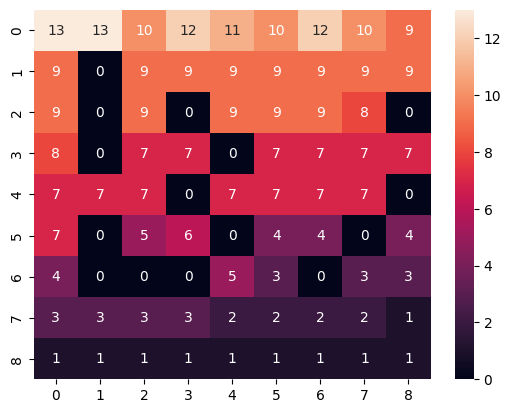

In [ ]:
printout = []
for f in facilities:
    printouttemp = []
    for p in positions:
        label = f'F{f}P{p}'
        value = sampleset.first.sample[label]
        printouttemp.append(value) 
    printout.append(printouttemp)
print(np.array(printout))
# print("\n",sampleset)


layout = np.zeros((9,9))
ctr = 1
for i in printout:
    for j in range(len(i)):
        if i[j] == 1:
            q = int(j/len(layout))
            r = j%len(layout)
            layout[q][r] = ctr
    ctr+=1
# print(layout)
# print("fitness = ",fitness(layout))
sns.heatmap(layout,annot = layout)

end = time.time()

print("\nRuntime = ", end-start)



<Axes: >

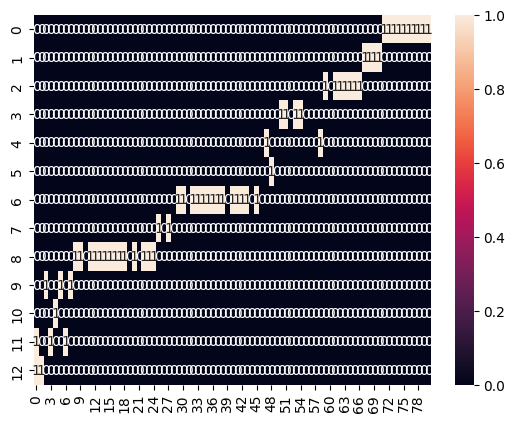

In [ ]:
sns.heatmap(printout,annot = printout, vmax= 1, vmin=0 )
